In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18aczbnhl,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18adairvu,No_TNS,None,-99.0,None
ZTF20aaiwhct,No_TNS,None,-99.0,None
ZTF20aberawv,No_TNS,None,-99.0,None


In [3]:
ann_dist_all_df = pd.read_csv('ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,0,2,2924,3500,2354,912,1275,3515,2770,3482,...,61.536526,63.347778,65.843559,65.899666,66.518990,67.332016,67.373749,68.640152,64.884181,61.319165
ZTF17aaazdba,1,2620,399,2256,3926,2484,1606,2186,932,1069,...,100.241852,106.455399,108.600021,109.778755,112.710617,112.818558,113.998962,114.044296,108.224602,101.604383
ZTF17aabwial,2,0,638,920,1275,2464,2924,3515,1769,912,...,60.490154,61.964592,64.846275,70.338516,70.470520,70.885178,73.281929,73.937187,67.075505,61.369470
ZTF17aacmssc,3,769,1258,1008,747,718,1878,899,387,843,...,35.456917,35.863552,37.003437,37.168324,38.337624,38.583427,38.685875,39.253487,36.930906,34.678148
ZTF18aaacqmh,4,654,2431,55,2198,1856,299,730,781,2502,...,118.893707,156.497009,165.020508,201.257355,204.361099,211.763382,216.045929,220.021484,178.738547,139.012462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackwyaz,4160,1427,4019,3617,2151,3415,2194,2800,3306,4159,...,46.417080,46.867256,47.307285,48.042274,48.896187,49.617691,49.661457,50.814774,47.721293,45.143207
ZTF21ackzfeh,4161,1204,3420,2877,1201,3931,2131,436,3097,3296,...,45.868549,47.581253,51.710529,53.964188,55.200634,55.353382,57.049538,57.588943,52.171330,47.657917
ZTF21acldmwy,4162,3141,1224,3011,3871,714,2662,2575,1251,2219,...,52.894600,53.093189,54.121025,54.204193,54.703674,55.056812,55.185112,55.278870,53.474642,50.893662


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,0.0,2.0,2924.0,3500.0,2354.0,912.0,1275.0,3515.0,2770.0,3482.0,...,66.518990,67.332016,67.373749,68.640152,64.884181,61.319165,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aaazdba,1.0,2620.0,399.0,2256.0,3926.0,2484.0,1606.0,2186.0,932.0,1069.0,...,112.710617,112.818558,113.998962,114.044296,108.224602,101.604383,Yes_TNS,TDE,0.022,ASAS-SN
ZTF17aabwial,2.0,0.0,638.0,920.0,1275.0,2464.0,2924.0,3515.0,1769.0,912.0,...,70.470520,70.885178,73.281929,73.937187,67.075505,61.369470,Yes_TNS,None,-99.000,ZTF
ZTF17aacmssc,3.0,769.0,1258.0,1008.0,747.0,718.0,1878.0,899.0,387.0,843.0,...,38.337624,38.583427,38.685875,39.253487,36.930906,34.678148,Yes_TNS,None,-99.000,GaiaAlerts
ZTF18aaacqmh,4.0,654.0,2431.0,55.0,2198.0,1856.0,299.0,730.0,781.0,2502.0,...,204.361099,211.763382,216.045929,220.021484,178.738547,139.012462,Yes_TNS,SN Ia,0.018,ASAS-SN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackwyaz,4160.0,1427.0,4019.0,3617.0,2151.0,3415.0,2194.0,2800.0,3306.0,4159.0,...,48.896187,49.617691,49.661457,50.814774,47.721293,45.143207,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackzfeh,4161.0,1204.0,3420.0,2877.0,1201.0,3931.0,2131.0,436.0,3097.0,3296.0,...,55.200634,55.353382,57.049538,57.588943,52.171330,47.657917,Yes_TNS,None,-99.000,ALeRCE
ZTF21acldmwy,4162.0,3141.0,1224.0,3011.0,3871.0,714.0,2662.0,2575.0,1251.0,2219.0,...,54.703674,55.056812,55.185112,55.278870,53.474642,50.893662,Yes_TNS,SN Ia,0.110,ZTF


<ipython-input-5-19ffaf0ecbcb>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


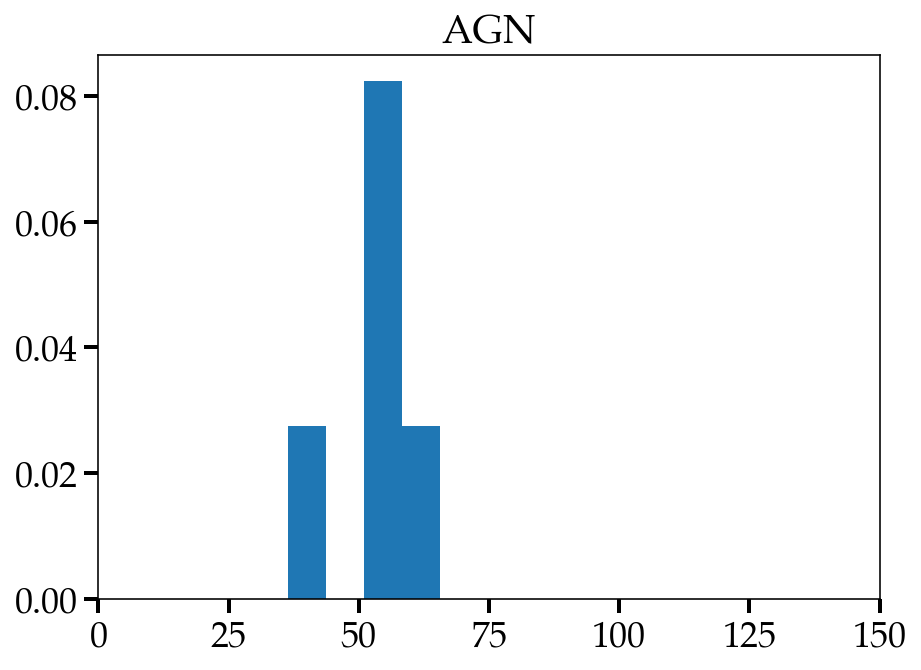

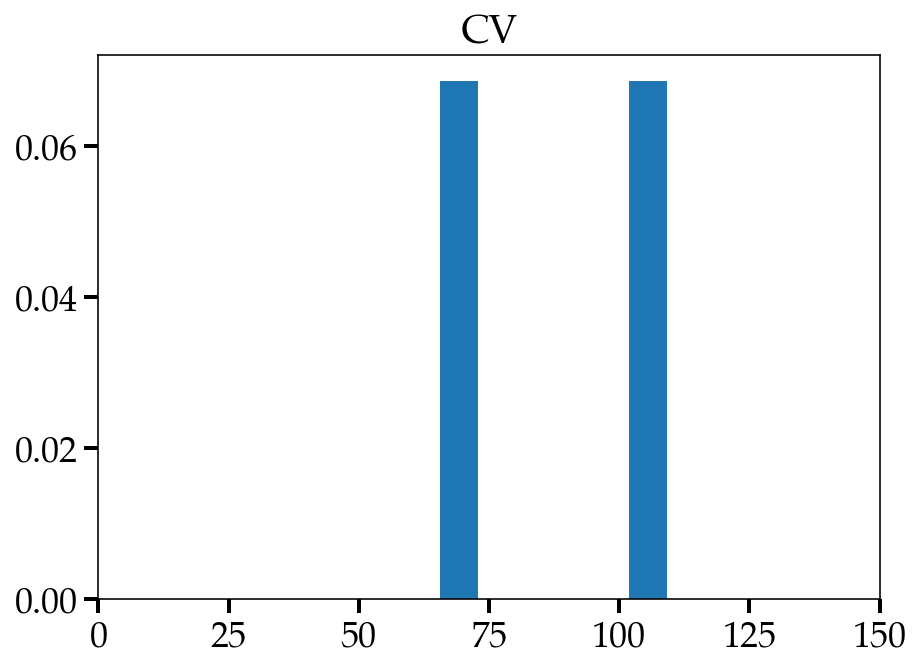

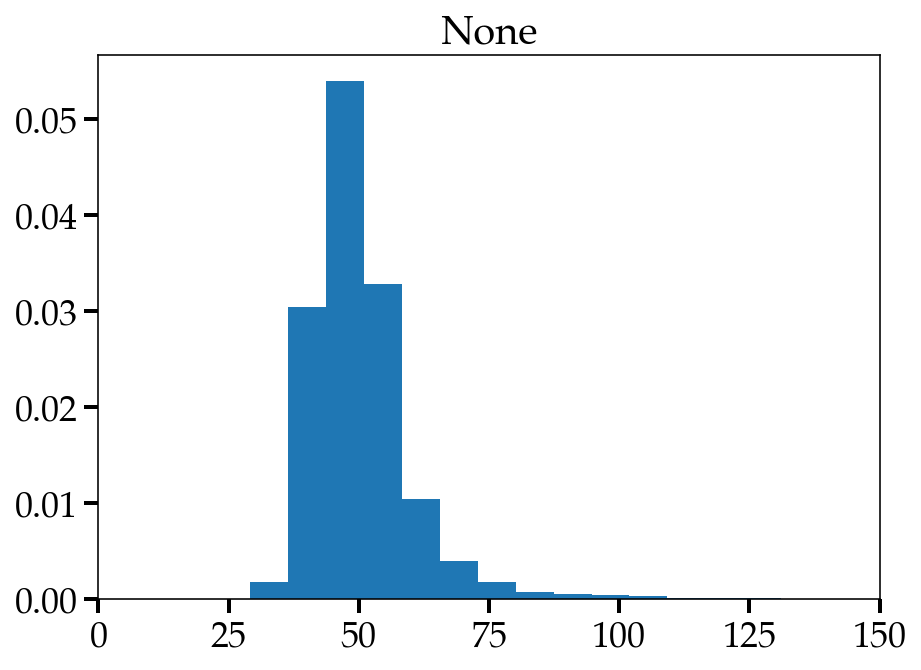

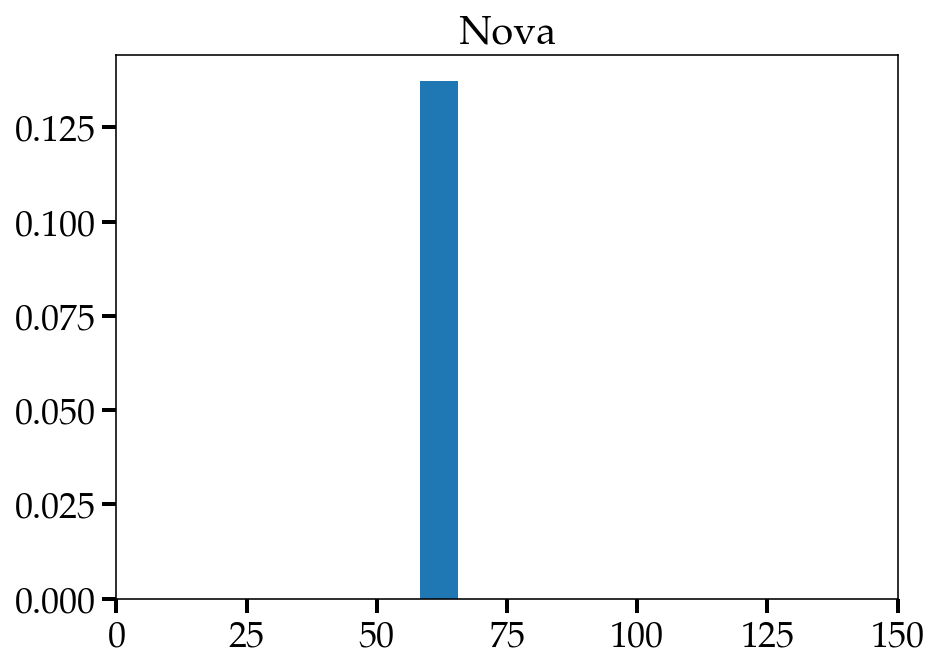

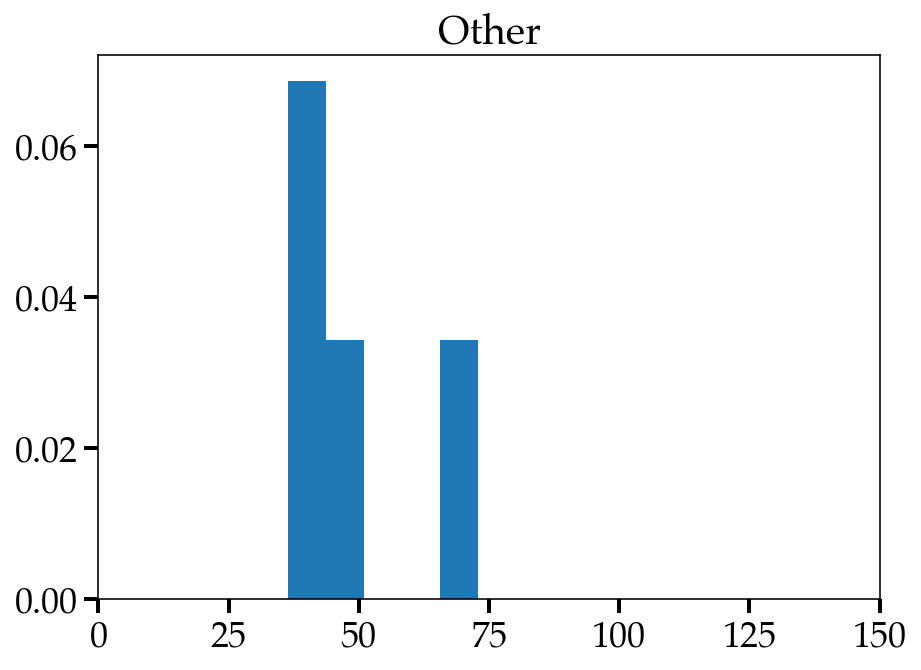

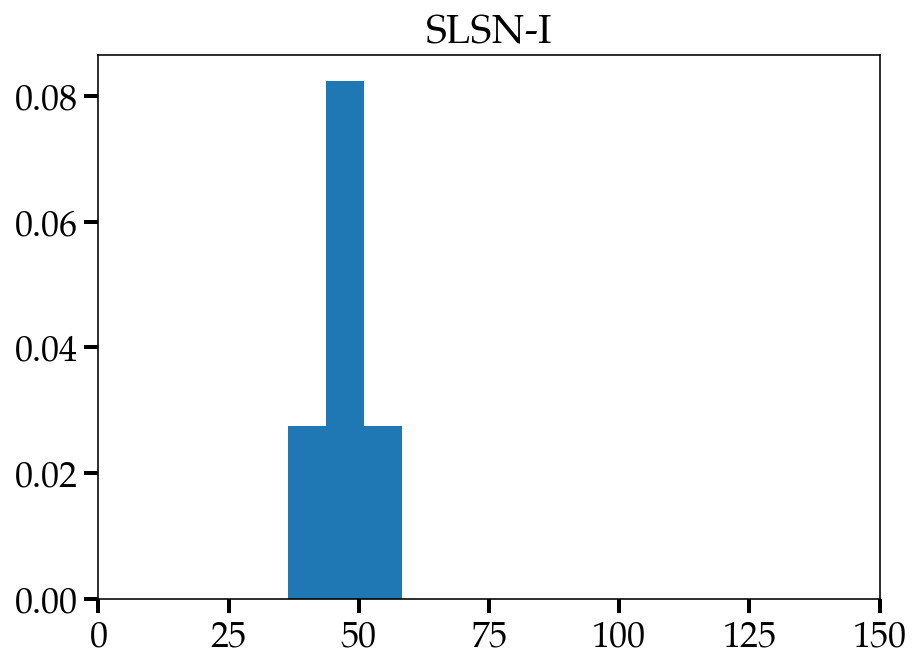

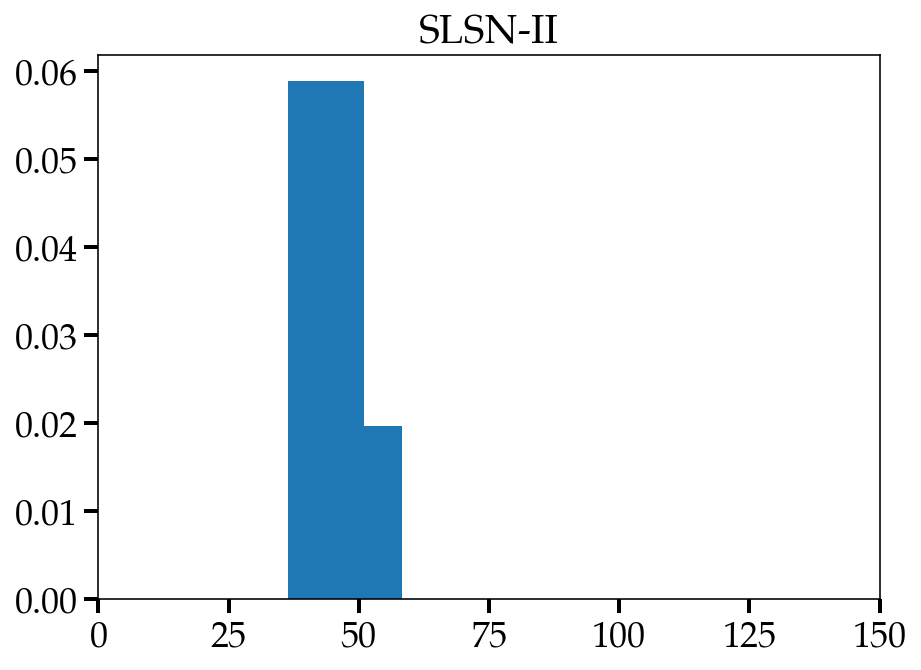

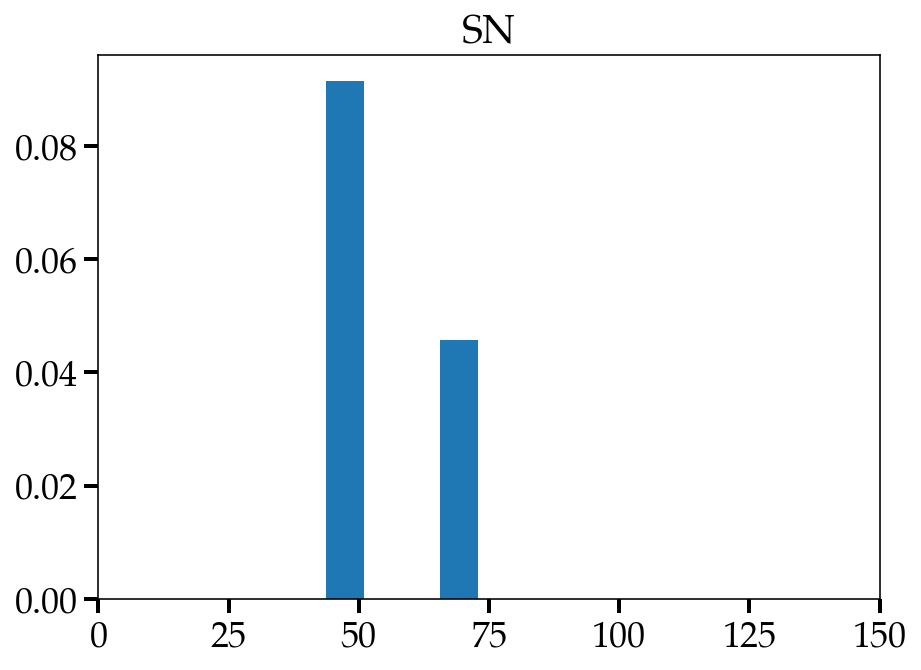

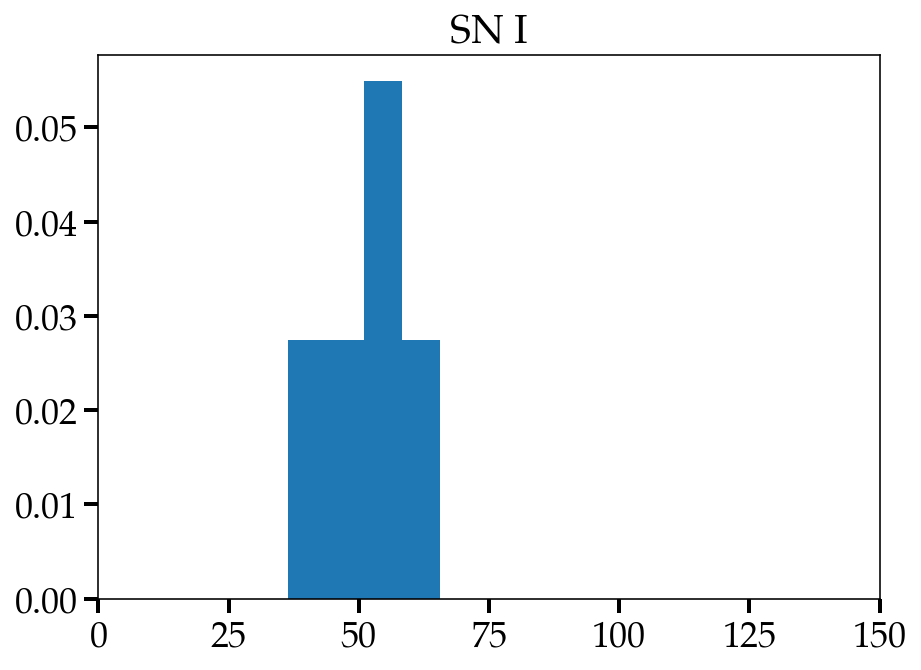

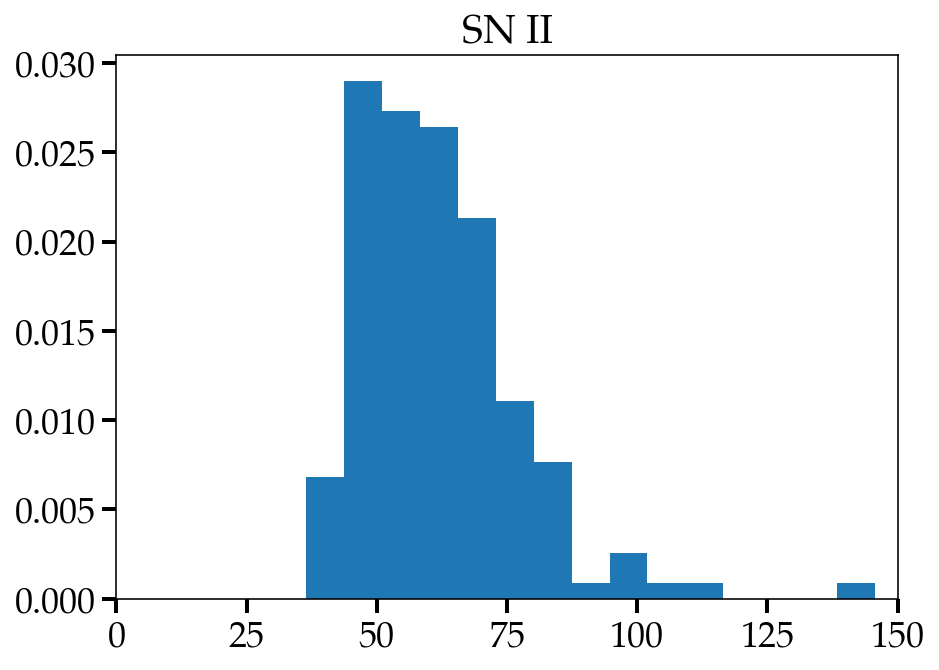

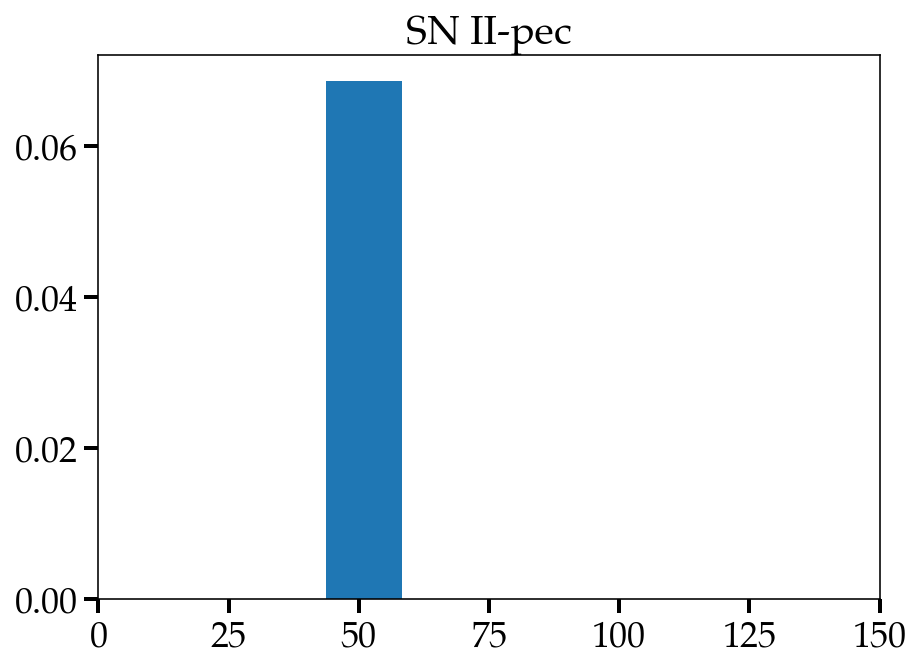

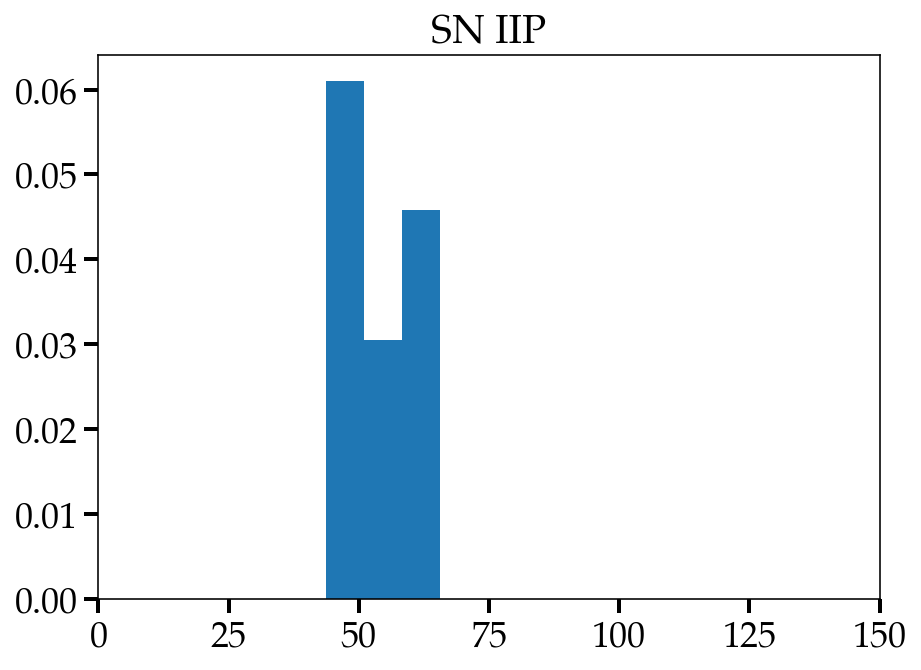

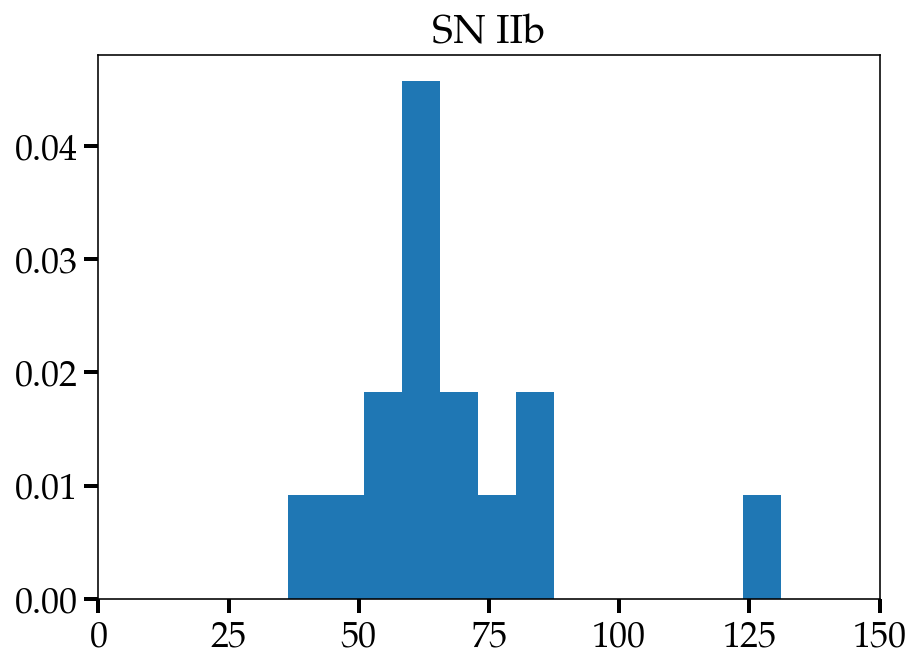

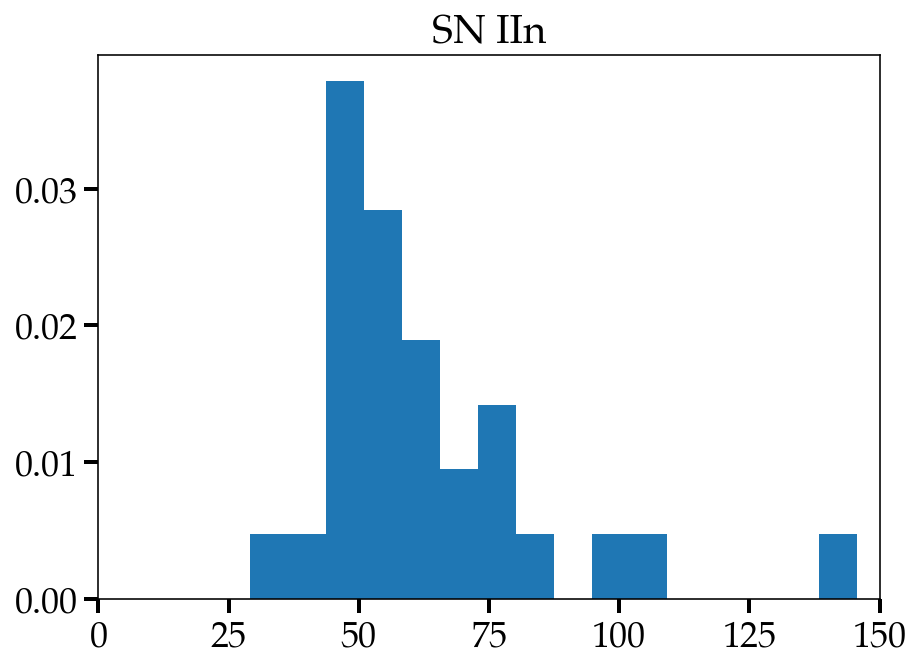

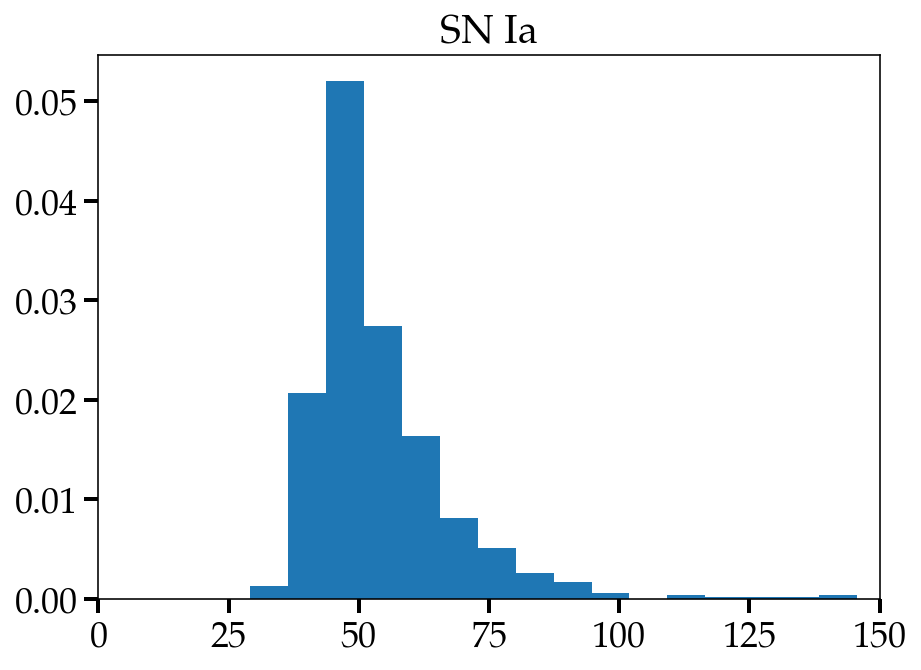

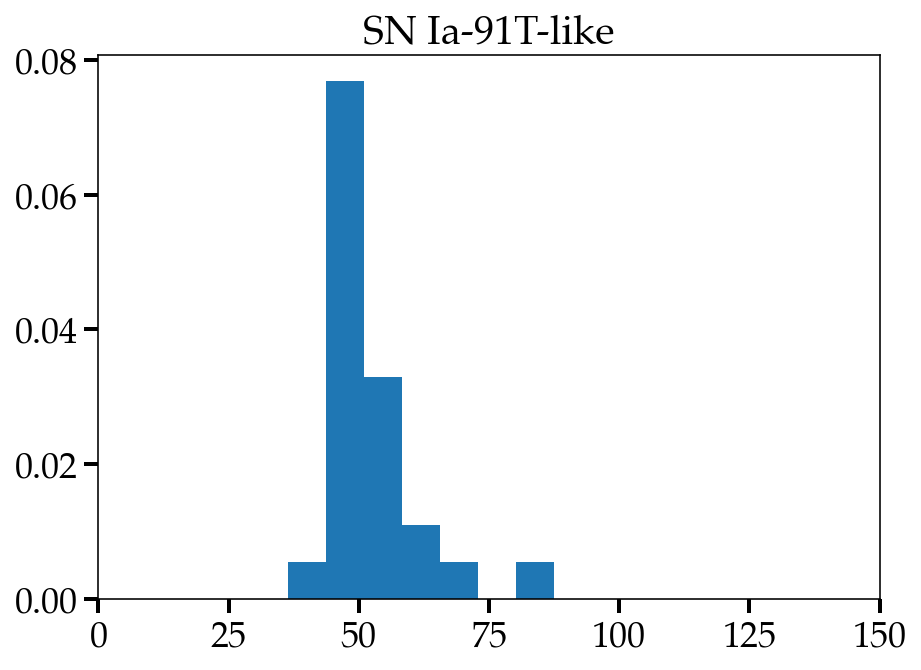

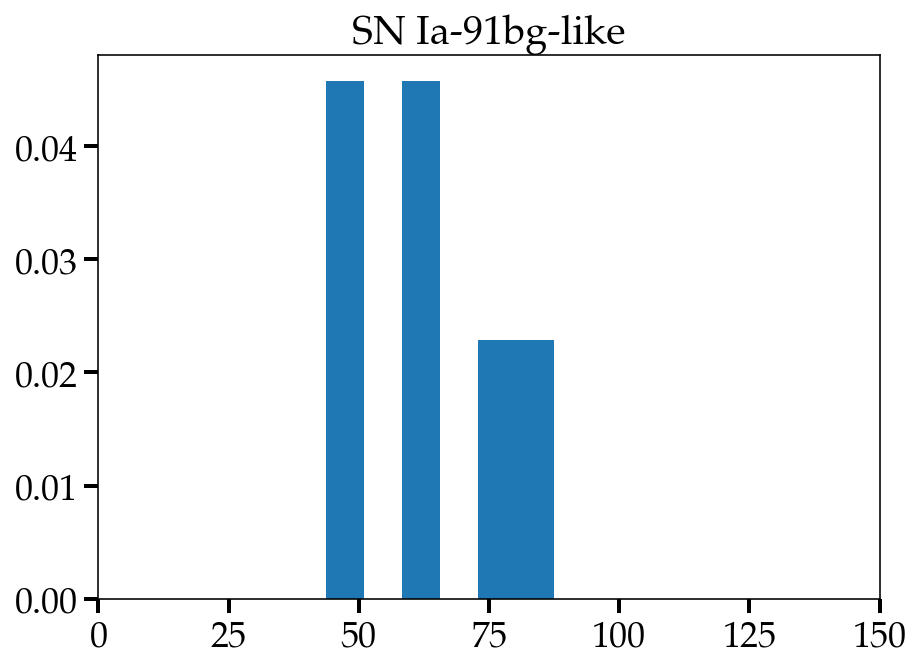

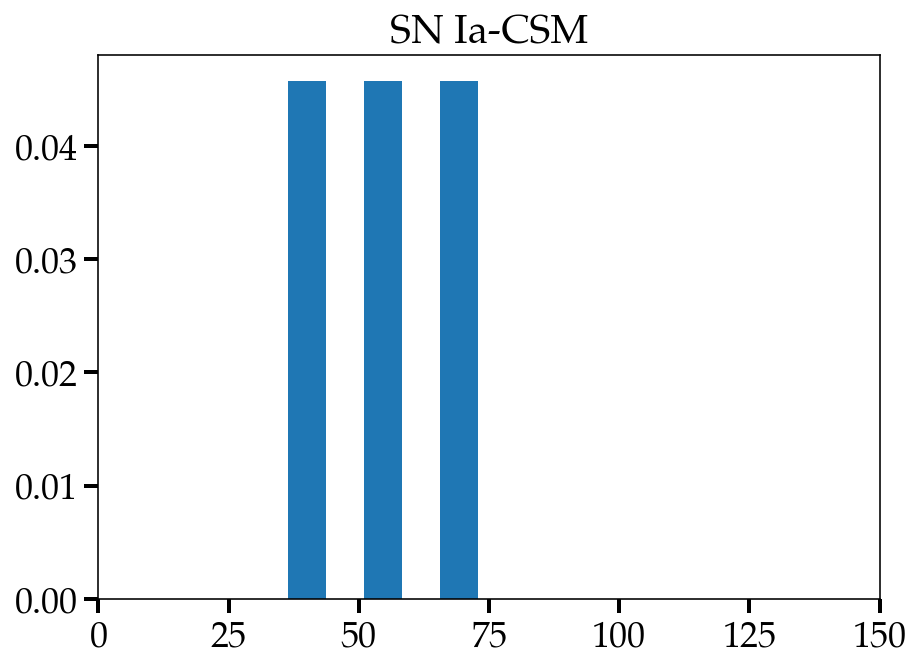

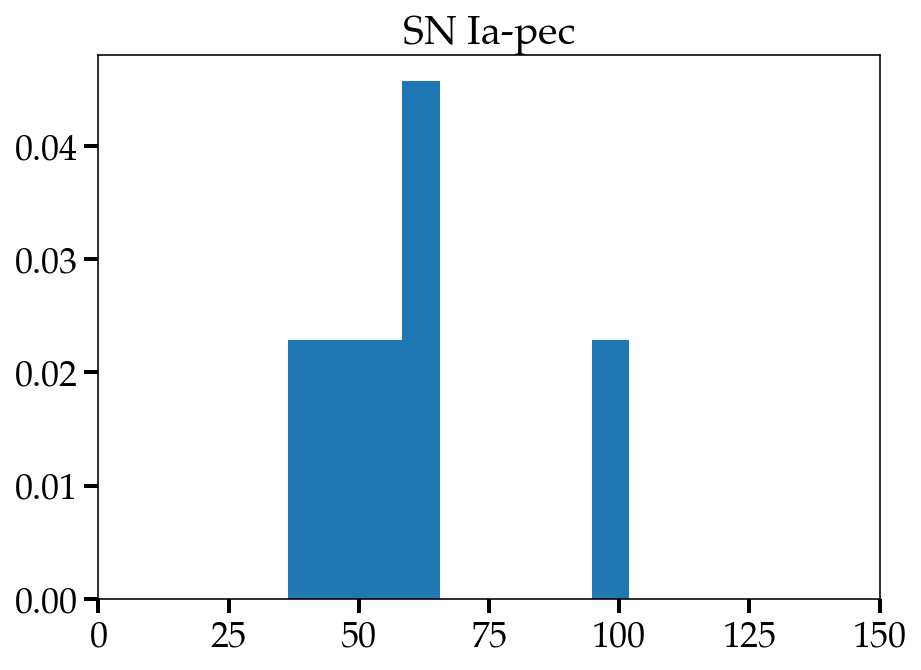

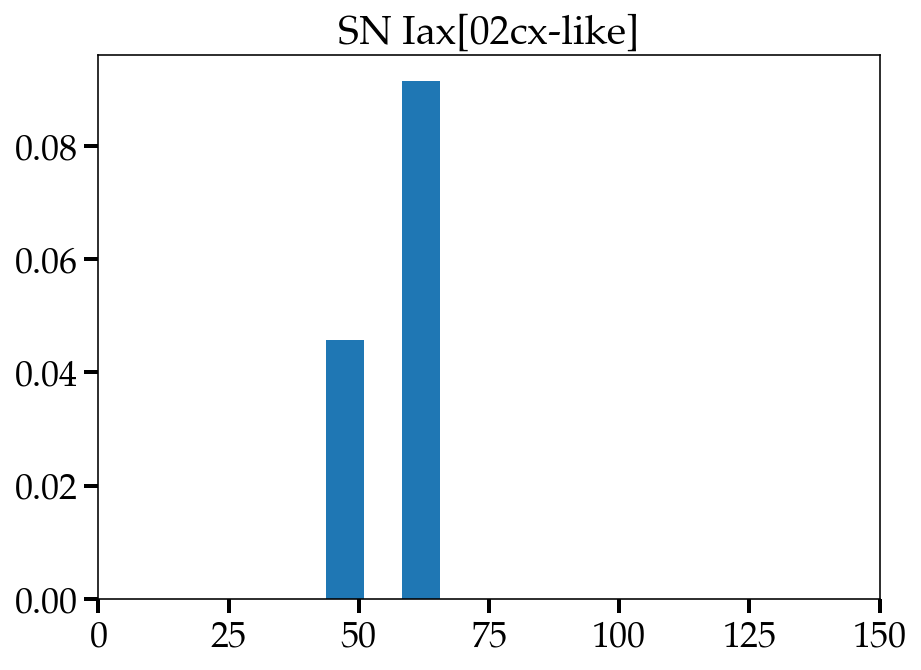

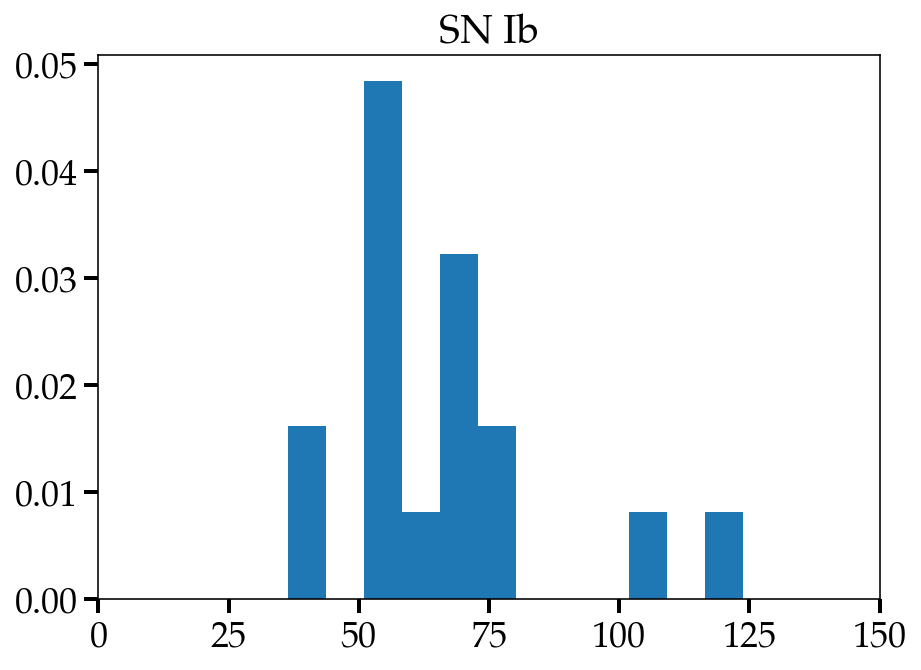

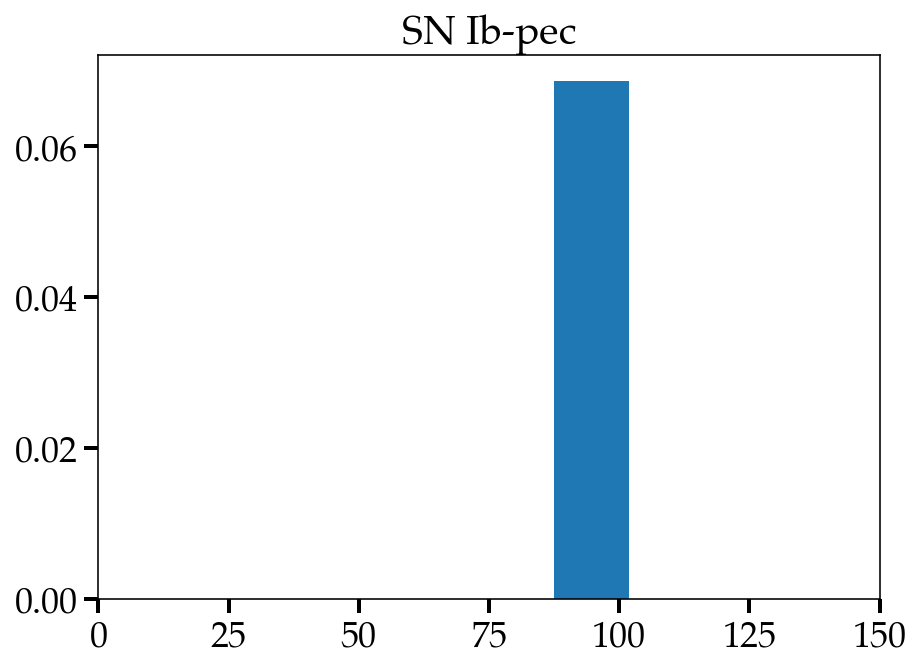

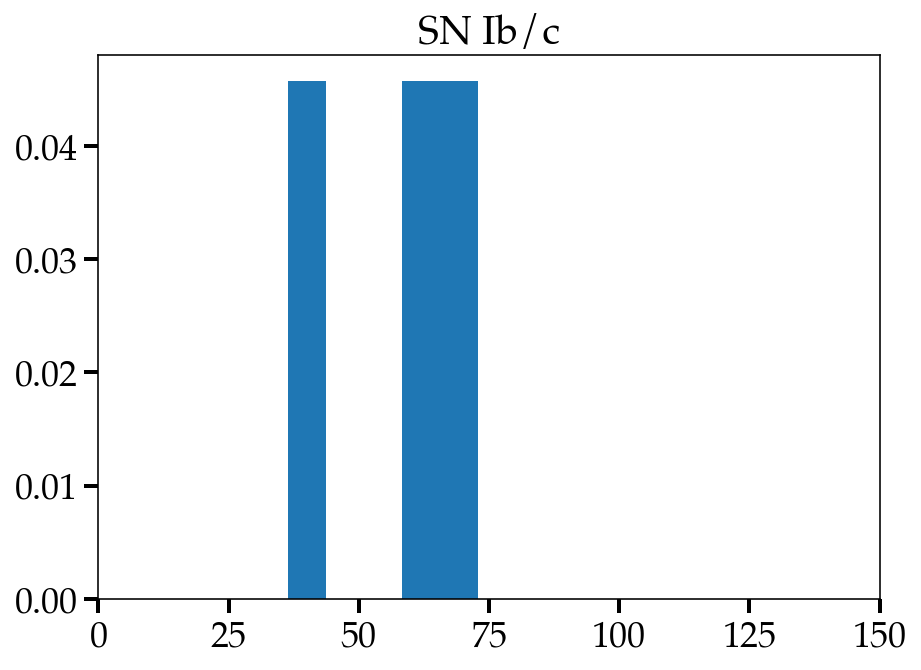

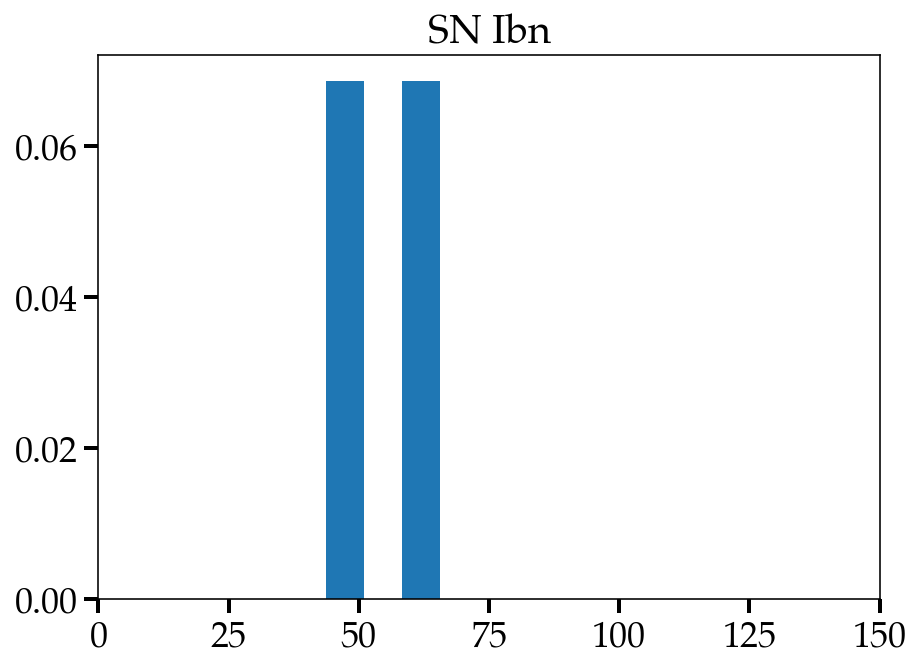

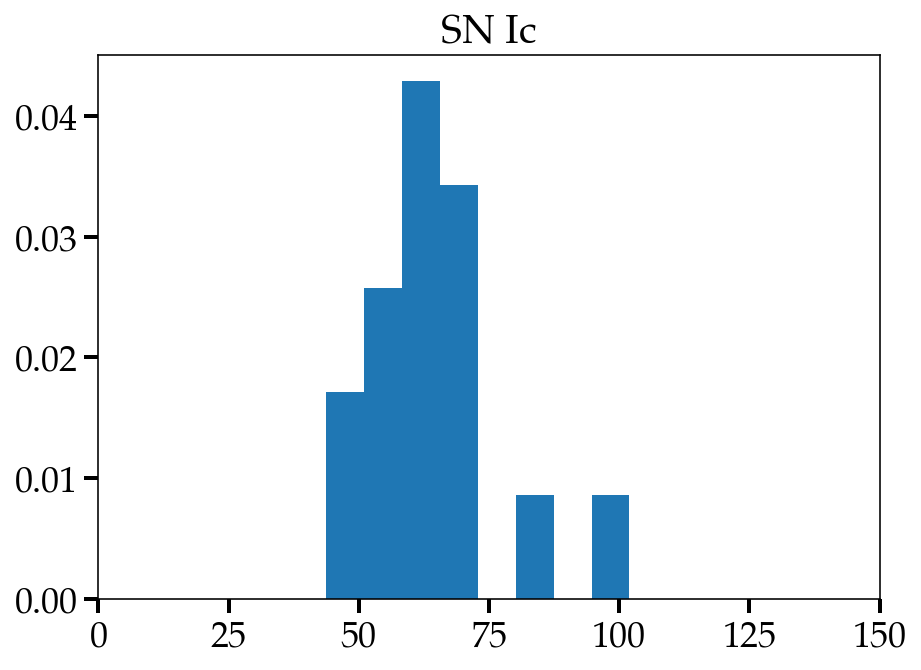

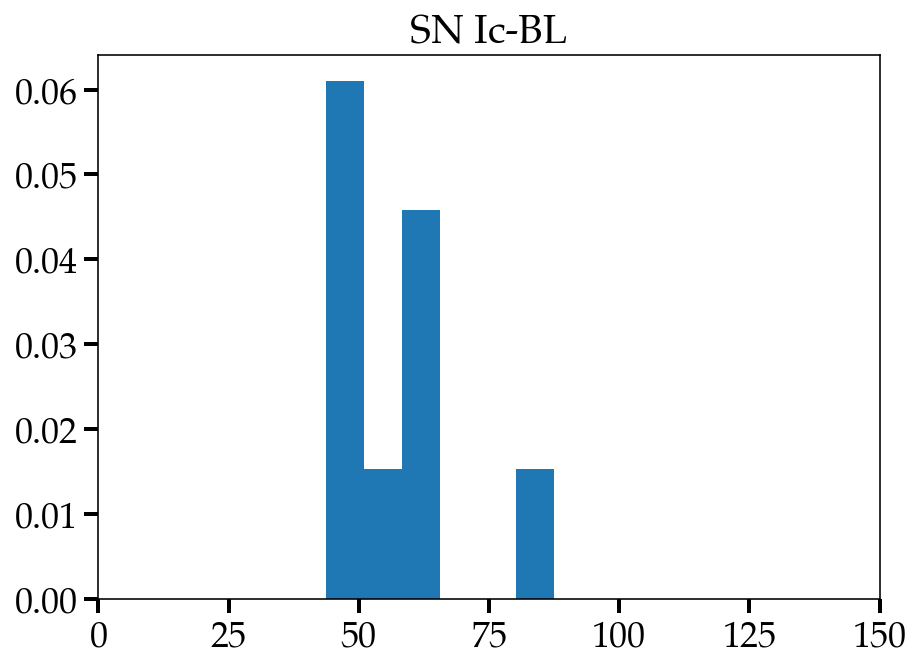

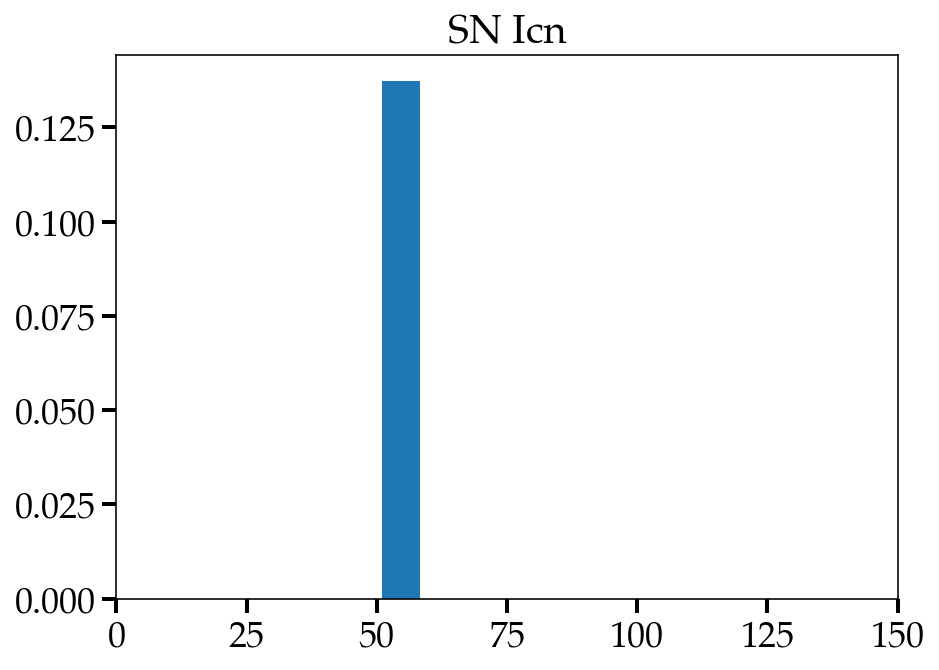

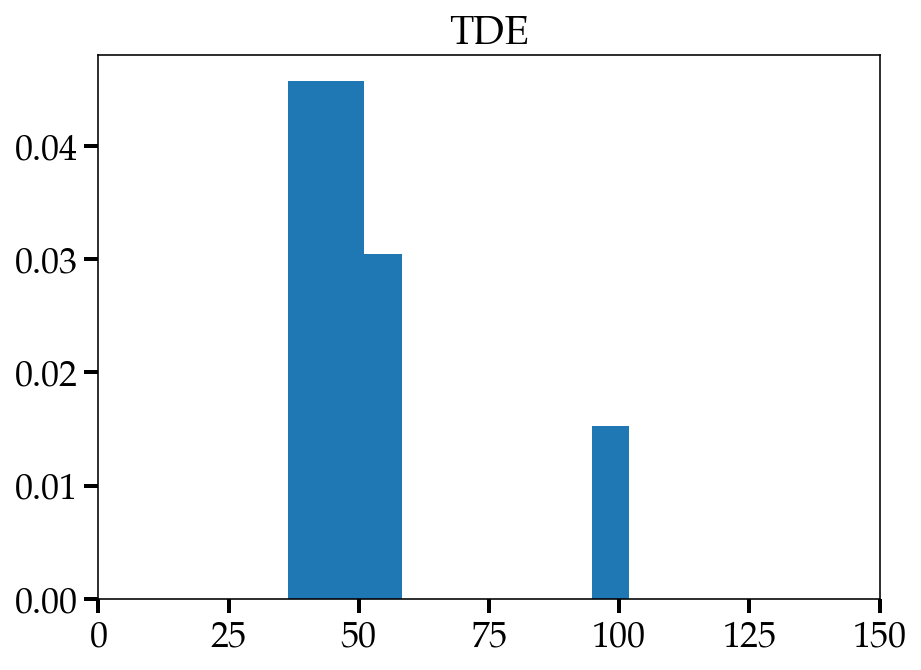

In [5]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    
    ax.set_title(cls)
    ax.set_xlim(0, 150)

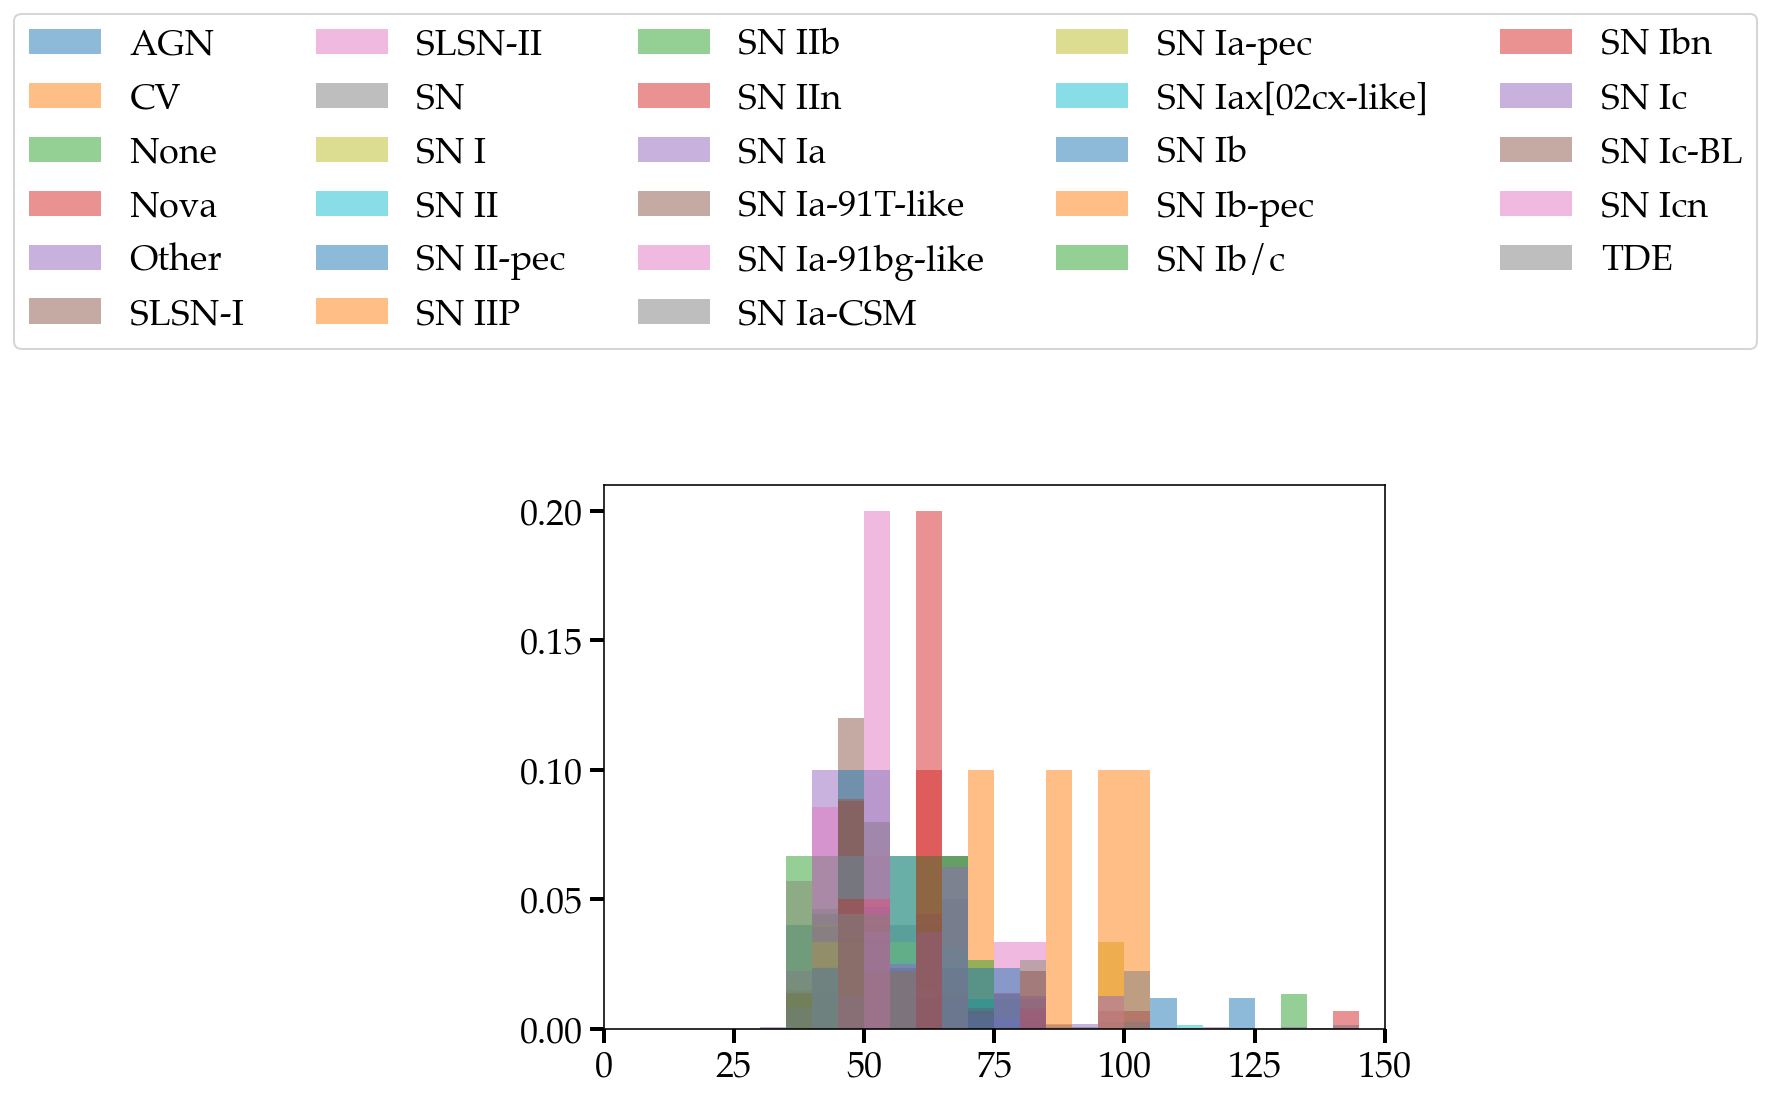

In [6]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(0, 150)
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

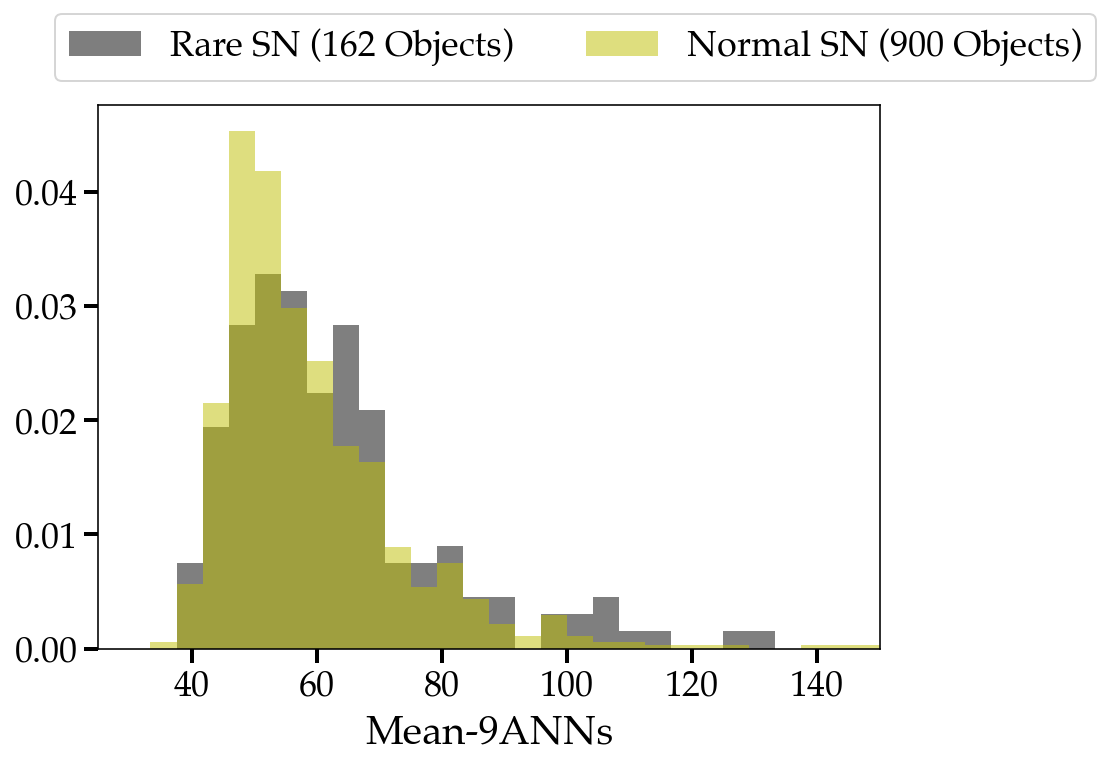

In [7]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

In [8]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-9ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-9ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.16049382716049382
P-value: 0.14200624663055675
The two distributions are likely the same.


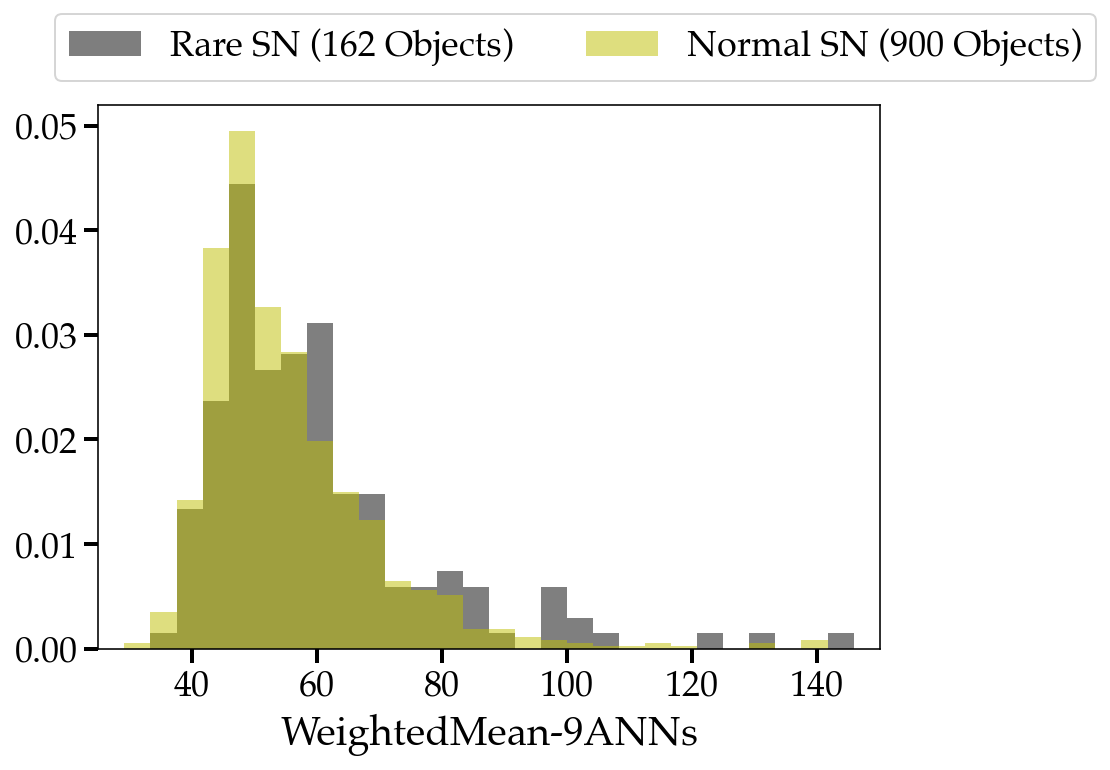

In [9]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('WeightedMean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_WeightedMean.png')
plt.show()

In [10]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["WeightedMean-9ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["WeightedMean-9ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.08024691358024691
P-value: 0.10943224259807409
The two distributions are likely the same.


## No statistical difference between Rare SN and Normal SN...

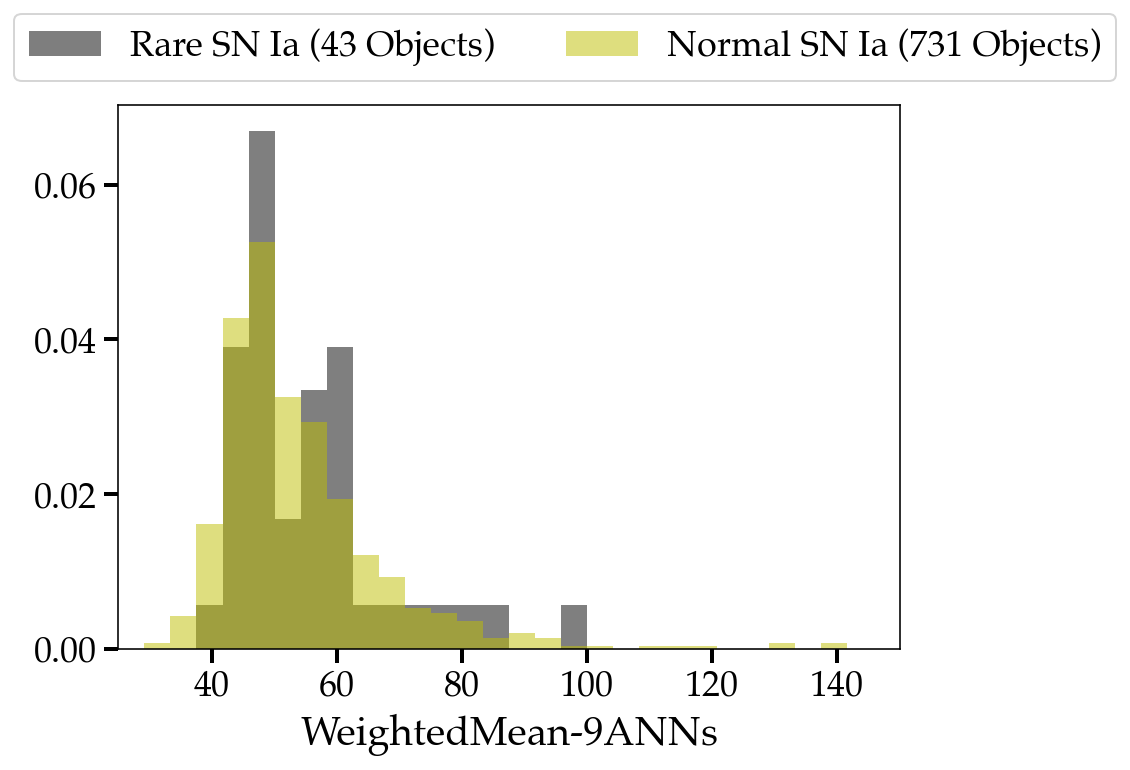

In [11]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('WeightedMean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_WeightedMean_Ia.png')
plt.show()

In [12]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df["WeightedMean-9ANNs"], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df["WeightedMean-9ANNs"], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.16279069767441862
P-value: 0.5718372299987049
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [13]:
merge_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,0.0,2.0,2924.0,3500.0,2354.0,912.0,1275.0,3515.0,2770.0,3482.0,...,66.518990,67.332016,67.373749,68.640152,64.884181,61.319165,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aaazdba,1.0,2620.0,399.0,2256.0,3926.0,2484.0,1606.0,2186.0,932.0,1069.0,...,112.710617,112.818558,113.998962,114.044296,108.224602,101.604383,Yes_TNS,TDE,0.022,ASAS-SN
ZTF17aabwial,2.0,0.0,638.0,920.0,1275.0,2464.0,2924.0,3515.0,1769.0,912.0,...,70.470520,70.885178,73.281929,73.937187,67.075505,61.369470,Yes_TNS,None,-99.000,ZTF
ZTF17aacmssc,3.0,769.0,1258.0,1008.0,747.0,718.0,1878.0,899.0,387.0,843.0,...,38.337624,38.583427,38.685875,39.253487,36.930906,34.678148,Yes_TNS,None,-99.000,GaiaAlerts
ZTF18aaacqmh,4.0,654.0,2431.0,55.0,2198.0,1856.0,299.0,730.0,781.0,2502.0,...,204.361099,211.763382,216.045929,220.021484,178.738547,139.012462,Yes_TNS,SN Ia,0.018,ASAS-SN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackwyaz,4160.0,1427.0,4019.0,3617.0,2151.0,3415.0,2194.0,2800.0,3306.0,4159.0,...,48.896187,49.617691,49.661457,50.814774,47.721293,45.143207,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackzfeh,4161.0,1204.0,3420.0,2877.0,1201.0,3931.0,2131.0,436.0,3097.0,3296.0,...,55.200634,55.353382,57.049538,57.588943,52.171330,47.657917,Yes_TNS,None,-99.000,ALeRCE
ZTF21acldmwy,4162.0,3141.0,1224.0,3011.0,3871.0,714.0,2662.0,2575.0,1251.0,2219.0,...,54.703674,55.056812,55.185112,55.278870,53.474642,50.893662,Yes_TNS,SN Ia,0.110,ZTF


In [14]:
full_ann_tns_cls_d = {}
for nm in merge_df.index:
    ann_tns_cls_l=[]
    for ann_num in range(0, 10):
        ix = int(merge_df.loc[nm][f"ann={ann_num}"])
        try:
            ann_tns_cls = merge_df.iloc[ix]["tns_cls"]
        except: ann_tns_cls = "IDXERROR"
        ann_tns_cls_l.append(ann_tns_cls)
    full_ann_tns_cls_d[nm] = ann_tns_cls_l


In [15]:
full_ann_tns_cls_d

{'ZTF17aaahrni': ['None',
  'None',
  'None',
  'None',
  'SN Ia',
  'SN IIn',
  'None',
  'SN Ic-BL',
  'None',
  'None'],
 'ZTF17aaazdba': ['TDE',
  'SN Ia-91T-like',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'SN Ic',
  'SN Ia'],
 'ZTF17aabwial': ['None',
  'None',
  'None',
  'SN II',
  'None',
  'None',
  'None',
  'SN Ic-BL',
  'None',
  'SN IIn'],
 'ZTF17aacmssc': ['None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'SN Ia',
  'SN Ia',
  'SN Ia-pec',
  'None'],
 'ZTF18aaacqmh': ['SN Ia',
  'None',
  'None',
  'SN Ia',
  'SN Ia',
  'SN Ia',
  'None',
  'None',
  'None',
  'None'],
 'ZTF18aabdjcx': ['None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'None'],
 'ZTF18aabdnbr': ['None',
  'None',
  'SN Ia',
  'SN Ia',
  'None',
  'SN II',
  'None',
  'None',
  'SN Ia',
  'None'],
 'ZTF18aabeszt': ['SN Ia',
  'None',
  'SN IIb',
  'None',
  'SN Ia',
  'None',
  'None',
  'None',
  'SN IIP',
  'None'],
 'ZTF18aabtkwb': [

In [16]:
col_list= [f'ann={col}_tns_cls' for col in range(0, 10)]
full_ann_tns_cls_df = pd.DataFrame.from_dict(full_ann_tns_cls_d, orient='index', columns=col_list)
full_ann_tns_cls_df.index.rename("ztf_object_id", inplace=True)
full_ann_tns_cls_df.to_csv('../dataframes/full_ann_tns_cls_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS.csv')
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
ztf_object_id,,,,,,,,,,
ZTF17aaahrni,None,None,None,None,SN Ia,SN IIn,None,SN Ic-BL,None,None
ZTF17aaazdba,TDE,SN Ia-91T-like,None,None,None,None,None,None,SN Ic,SN Ia
ZTF17aabwial,None,None,None,SN II,None,None,None,SN Ic-BL,None,SN IIn
ZTF17aacmssc,None,None,None,None,None,None,SN Ia,SN Ia,SN Ia-pec,None
ZTF18aaacqmh,SN Ia,None,None,SN Ia,SN Ia,SN Ia,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
ZTF21ackwyaz,IDXERROR,None,None,None,None,None,None,None,None,IDXERROR
ZTF21ackzfeh,IDXERROR,None,SN Ia,None,None,None,SN II,None,None,None
ZTF21acldmwy,IDXERROR,SN Ia,None,None,None,None,None,SN Ia,None,SN Ia


In [17]:
full_ann_tns_cls_df.loc['ZTF21aarwlht']

ann=0_tns_cls         None
ann=1_tns_cls         None
ann=2_tns_cls         None
ann=3_tns_cls         None
ann=4_tns_cls        SN Ia
ann=5_tns_cls    SN Ia-CSM
ann=6_tns_cls        SN Ia
ann=7_tns_cls        SN Ia
ann=8_tns_cls         None
ann=9_tns_cls         None
Name: ZTF21aarwlht, dtype: object

In [18]:
# This IS wrong! ....